In [1]:
import gym
import ale_py # necessary for gym enviornment creation
import time
import torch as T
import torch.nn as nn
from supersuit import frame_stack_v1, color_reduction_v0
from supersuit import frame_skip_v0, max_observation_v0, dtype_v0, resize_v0, clip_reward_v0
from torchvision import transforms
from einops import rearrange
import matplotlib.pyplot as plt
import torch.nn.functional as F
import kornia as K
import numpy as np

/home/lars/code/ba_env/lib/python3.8/site-packages/supersuit/__init__.py:20: UserWarning: You're using SuperSuit 3.0, released 7/7/21. The entire codebase has been rewritten or refactored as part of this release. While we've tested it thoroughly, please ensure everything you're doing still works properly and report any issues at https://github.com/PettingZoo-Team/SuperSuit. This warning will be removed 2 months after release.
  warnings.warn("You're using SuperSuit 3.0, released 7/7/21. The entire codebase has been rewritten or refactored as part of this release. While we've tested it thoroughly, please ensure everything you're doing still works properly and report any issues at https://github.com/PettingZoo-Team/SuperSuit. This warning will be removed 2 months after release.")


In [9]:
FRAMES_TO_STACK = 4
FRAMES_TO_SKIP = 4
MAX_OVER_OBS = 4

X_DIM = 84
Y_DIM = 84


# NUM_ACTIONS = gym.spaces.utils.flatdim(env.action_space)

In [3]:
def crop_bottom(x):
    return x[:,:,:172,:]

In [4]:
def preprocess(img):
    img = T.from_numpy(img) / 255
    
    if len(img.shape) == 3: # if no fourth dim, batch size is missing
        img = img.unsqueeze(0)

    img = rearrange(img, 'b h w c -> b c h w')
    return img

In [5]:
def plot_state(state, big=False):
    fig = plt.figure(figsize=(24,12))
    if big:
        plt.imshow(state[0][0], cmap='gray');
        return
    
    for i in range(state.shape[1]):
        fig.add_subplot(1, FRAMES_TO_STACK, i + 1)
        plt.imshow(state[0][i], cmap='gray');

In [89]:
def create_env(name='MsPacman', render=None):
    env = gym.make('ALE/' + name + '-v5',
                    obs_type='grayscale',             # ram | rgb | grayscale
                 #   frame_skip=5,                    # frame skip. doesn't work
                    mode=0,                           # game mode, see Machado et al. 2018
                    difficulty=0,                     # game difficulty, see Machado et al. 2018
                    repeat_action_probability=0.25,   # Sticky action probability
                    full_action_space=True,           # Use all actions
                    render_mode=render                # None | human | rgb_array
    )

    env = clip_reward_v0(env, lower_bound=-1, upper_bound=1)
    env = resize_v0(env, X_DIM, Y_DIM, linear_interp=True)
    env = frame_stack_v1(env, FRAMES_TO_STACK)
    env = frame_skip_v0(env, FRAMES_TO_SKIP)
    
    return env

In [90]:
def run_episode(env, early_break=True):
    done = False
    s = env.reset()
    i = 0
    rewards = []

    while not done:
        action = env.action_space.sample()
        s, r, done, _ = env.step(action)

        rewards.append(r)
        
        i += 1
        if early_break and i == 20:
            env.close()            
            return s
    
    env.close()

In [91]:
env = create_env()

In [94]:
s = run_episode(env)
s = preprocess(s)

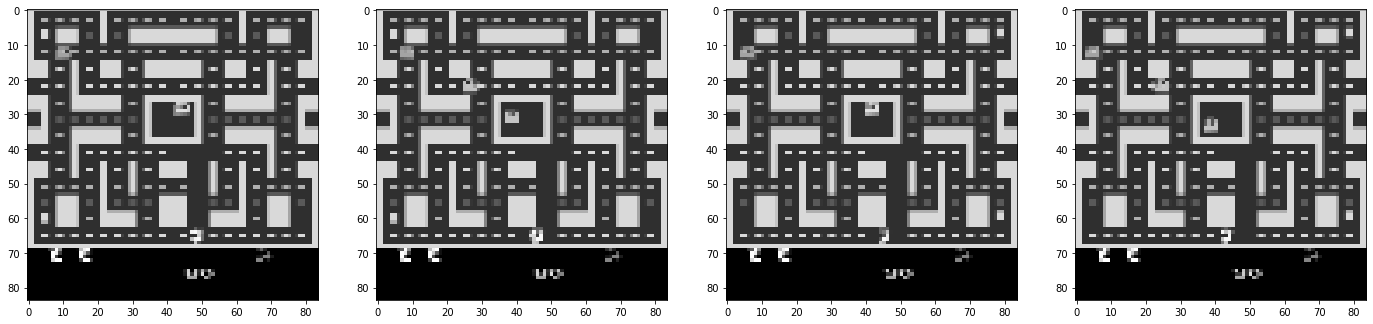

In [96]:
plot_state(s, big=False) # Lin Int

In [20]:
class ContrastiveLearner(nn.Module):
    def __init__(self, num_actions, frame_stack, resnet_dim=2048, project_dim=2048):
        super(ContrastiveLearner, self).__init__()
        
        self.encoder = models.resnet50(pretrained=False, num_classes=resnet_dim)
        # self.encoder.conv1 = nn.Conv2d(frame_stack, 64, (7, 7), (2, 2), (3, 3), bias=False)
        self.layer_norm = nn.LayerNorm(resnet_dim)
        
        self.project_head = nn.Sequential(
            nn.Linear(resnet_dim, 15),
            nn.ReLU(),
            nn.Linear(15, 15),
            nn.ReLU(),
            nn.Linear(15, 15),
            nn.ReLU(),
            nn.Linear(15, project_dim)
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.layer_norm(x)
        x = T.tanh(x)
        
        return x
    
    def encode(self, x):
        return self.forward(x)
    
    def project(self, x):
        x = self.forward(x)
        x = self.project_head(x)
        
        return x

In [73]:
class DataAugment(nn.Module):
    def __init__(self):
        super().__init__()

        #self.jitter = K.augmentation.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0)
        
        # TODO change to rotation
        self.flip = nn.Sequential(
            K.augmentation.RandomHorizontalFlip(p=0.5),
            K.augmentation.RandomVerticalFlip(p=0.5)
        )
    
    @T.no_grad()
    def forward(self, x):
        #x = self.jitter(x)
        x = self.flip(x)
        
        return x

In [74]:
dm = DataAugment()

In [21]:
plot_state(dm(s))

NameError: name 'dm' is not defined